# Predicting

## Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from typing import Callable

## Load dataset

In [2]:
df = pd.read_csv('../data/prepared.csv')
df.head()

,movie,year,category,nominee,bafta,globe,oscar,rated,runtime,director,...,musical,romance,music,action,drama,comedy,sport,history,animation,thriller
0,Raging Bull,1980,actor,Robert De Niro,0,1,1,R,129,Martin Scorsese,...,0,0,0,0,1,0,1,0,0,0
1,Raging Bull,1980,director,Martin Scorsese,0,0,0,R,129,Martin Scorsese,...,0,0,0,0,1,0,1,0,0,0
2,Raging Bull,1980,picture,Raging Bull,0,0,0,R,129,Martin Scorsese,...,0,0,0,0,1,0,1,0,0,0
3,The Great Santini,1980,actor,Robert Duvall,0,0,0,PG,115,Lewis John Carlino,...,0,0,0,0,1,0,0,0,0,0
4,The Elephant Man,1980,actor,John Hurt,1,0,0,PG,124,David Lynch,...,0,0,0,0,1,0,0,0,0,0


## Encode categorical values

In [3]:
encoder = LabelEncoder()
df['rated'] = encoder.fit_transform(df.rated)
df['director'] = encoder.fit_transform(df.director)
df['language'] = encoder.fit_transform(df.language)

In [4]:
df.head()

,movie,year,category,nominee,bafta,globe,oscar,rated,runtime,director,...,musical,romance,music,action,drama,comedy,sport,history,animation,thriller
0,Raging Bull,1980,actor,Robert De Niro,0,1,1,4,129,162,...,0,0,0,0,1,0,1,0,0,0
1,Raging Bull,1980,director,Martin Scorsese,0,0,0,4,129,162,...,0,0,0,0,1,0,1,0,0,0
2,Raging Bull,1980,picture,Raging Bull,0,0,0,4,129,162,...,0,0,0,0,1,0,1,0,0,0
3,The Great Santini,1980,actor,Robert Duvall,0,0,0,2,115,152,...,0,0,0,0,1,0,0,0,0,0
4,The Elephant Man,1980,actor,John Hurt,1,0,0,2,124,57,...,0,0,0,0,1,0,0,0,0,0


## Split train and test data

In [5]:
predict_year = 2020
categories = pd.unique(df.category)

In [6]:
train = df[df.year < predict_year]
test = df[df.year == predict_year]

## Predict

In [7]:
to_drop = ['movie', 'year', 'nominee', 'category']
non_genres = [
    'movie', 'year', 'category', 'nominee',
    'bafta', 'oscar', 'globe', 'rated', 'runtime', 'director', 
    'language', 'imdb_score', 'imdb_votes', 'rt_score', 
    'metascore', 'other_win', 'other_nom'
]
genres = [el for el in df.columns if el not in non_genres]
important = [
    'bafta', 'globe', 'runtime', 'imdb_score', 
    'metascore', 'other_win', 'other_nom', 
    'western', 'music', 'drama'
]

In [8]:
def get_train(category: str) -> tuple[pd.DataFrame, pd.Series]:
    data = train[train.category == category].drop(columns=to_drop, axis=1)
    train_Y, train_X = data['oscar'], data.drop('oscar', axis=1)
    return train_X, train_Y

In [9]:
def get_test(category: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    data = test[test.category == category]
    movies = data[['movie', 'year', 'nominee', 'oscar']]
    return movies, data.drop(columns=[*to_drop, 'oscar'], axis=1)

In [10]:
def is_correct_prediction(probs: np.ndarray, expected: np.ndarray) -> bool:
    return expected.iloc[probs.argmax()] == 1

In [11]:
def plot_predictions(method: str, predict: Callable) -> None:
    correct_num = 0
    categories_num = len(categories)
    
    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(categories_num, hspace=0.7)
    axs = gs.subplots()
  
    for idx, category in enumerate(categories):
        prediction = predict(category)
        probs, actual = prediction['prob'], prediction['oscar']
        is_correct = is_correct_prediction(probs, actual)
        correct_num += int(is_correct)
        color = 'green' if is_correct else 'red'
        
        axs[idx].set_title(f'Best {category.capitalize()}', color=color, weight='bold')
        axs[idx].set_xlabel('probability')
        axs[idx].set_ylabel('nominee')
        axs[idx].barh(prediction.nominee, prediction.prob, color=color)
    
    fig.suptitle(f'{method} ({correct_num} / {categories_num})', weight='bold', fontsize=16)

In [12]:
def predict(clf, category: str) -> pd.DataFrame:
    movies, test_X = get_test(category)
    probs = clf.predict_proba(test_X)[:, 1]
    movies['prob'] = probs / (np.sum(probs) + np.finfo(float).eps)
    return movies.sort_values(by='prob')

In [13]:
def clear_non_major(data: pd.DataFrame) -> pd.DataFrame:
    major_genres =  data[genres].sum(axis=0).\
        sort_values(axis=0, ascending=False)[:5].index
    to_drop = [el for el in data.columns if\
               el not in major_genres and el not in non_genres]
    return data.drop(columns=to_drop, axis=0)

### Logistic Regression

In [14]:
def predict_logistic_regression(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)
    clf = LogisticRegression(random_state=4)
    clf.fit(train_X, train_Y)
    return predict(clf, category)

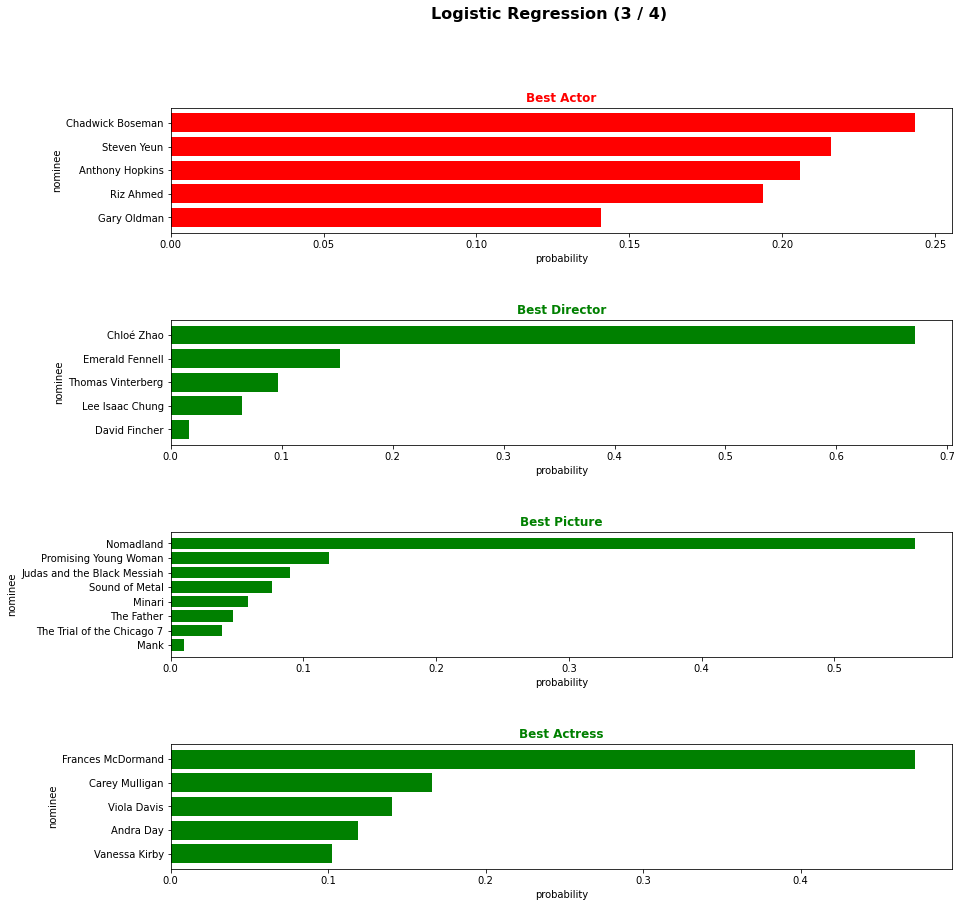

In [15]:
plot_predictions('Logistic Regression', predict_logistic_regression)

### Logistic Regression (major genres)

In [16]:
def predict_logistic_regression_major(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)
    movies, test_X = get_test(category)
    
    train_X = clear_non_major(train_X)
    test_X = clear_non_major(test_X)
    
    lrc = LogisticRegression()
    lrc.fit(train_X, train_Y)
    
    probs = lrc.predict_proba(test_X)[:, 1]
    movies['prob'] = probs / np.sum(probs)
    return movies.sort_values(by='prob')

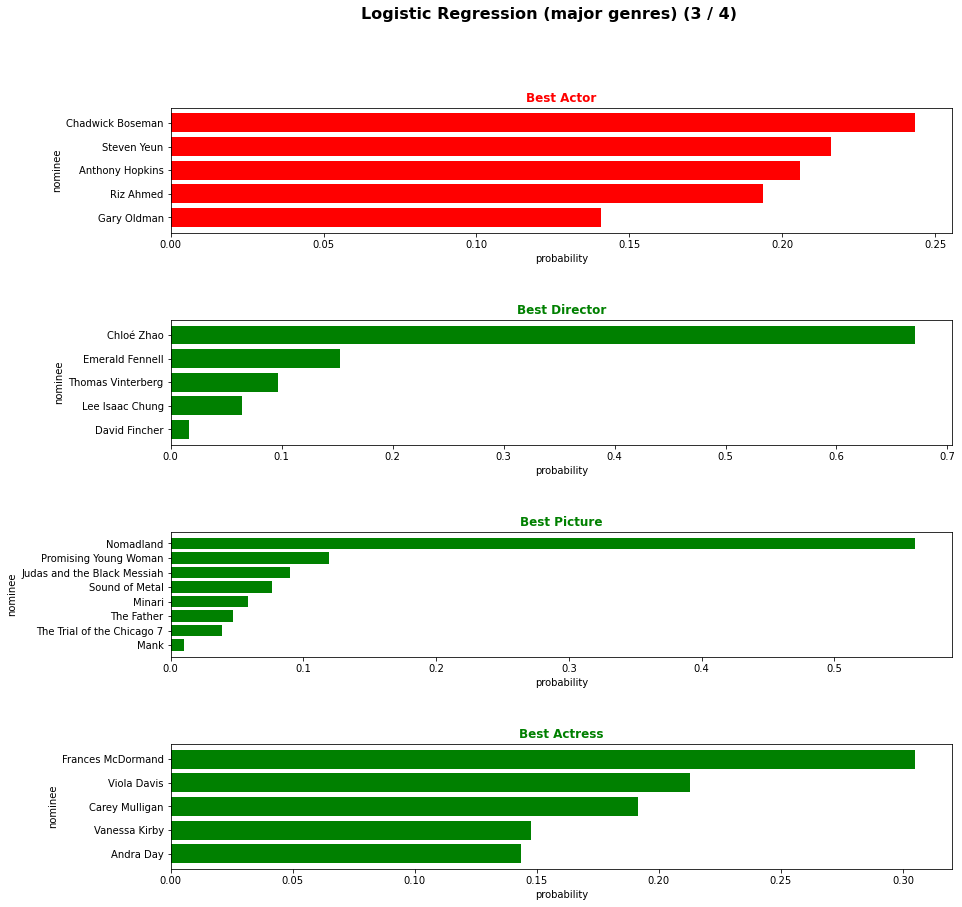

In [17]:
plot_predictions('Logistic Regression (major genres)', predict_logistic_regression_major)

### Random forest

In [18]:
def predict_random_forest(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category) 
    rfc = RandomForestClassifier(n_estimators = 300, random_state=4)
    rfc.fit(train_X, train_Y)
    return predict(rfc, category)

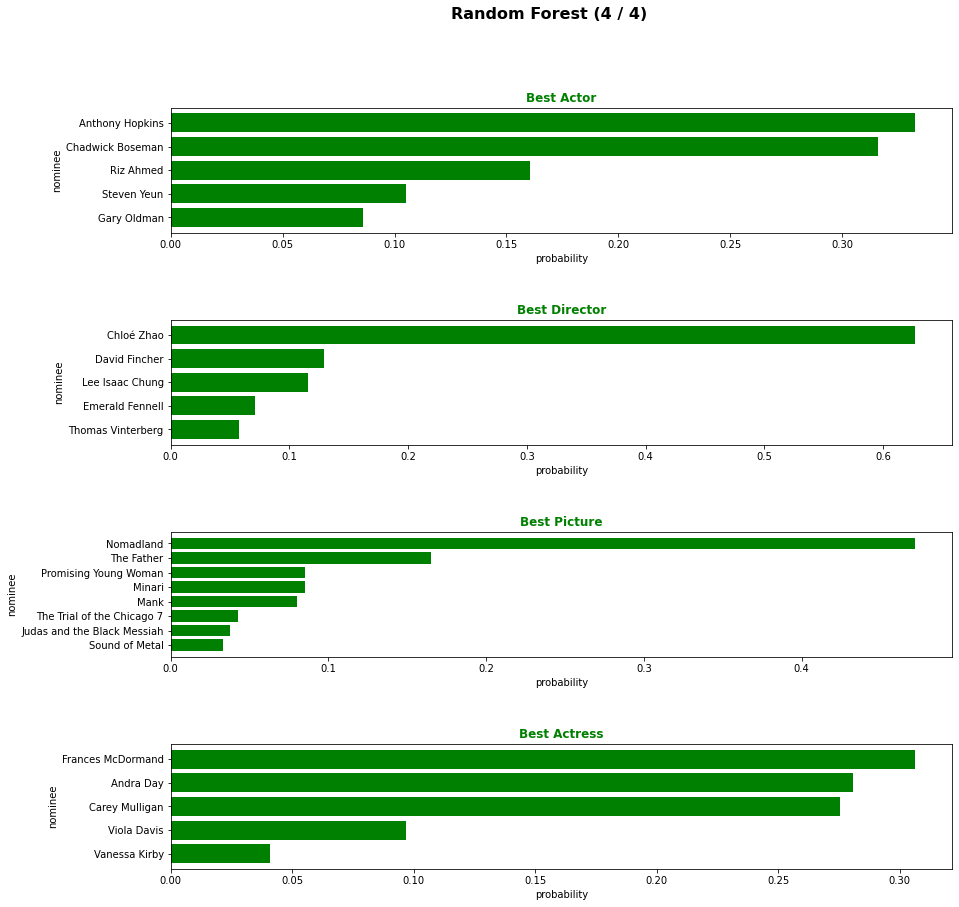

In [19]:
plot_predictions('Random Forest', predict_random_forest)

### XGBoost

In [20]:
def predict_xgboost(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)
    
    xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)
    xgbc.fit(train_X, train_Y)
    return predict(xgbc, category)

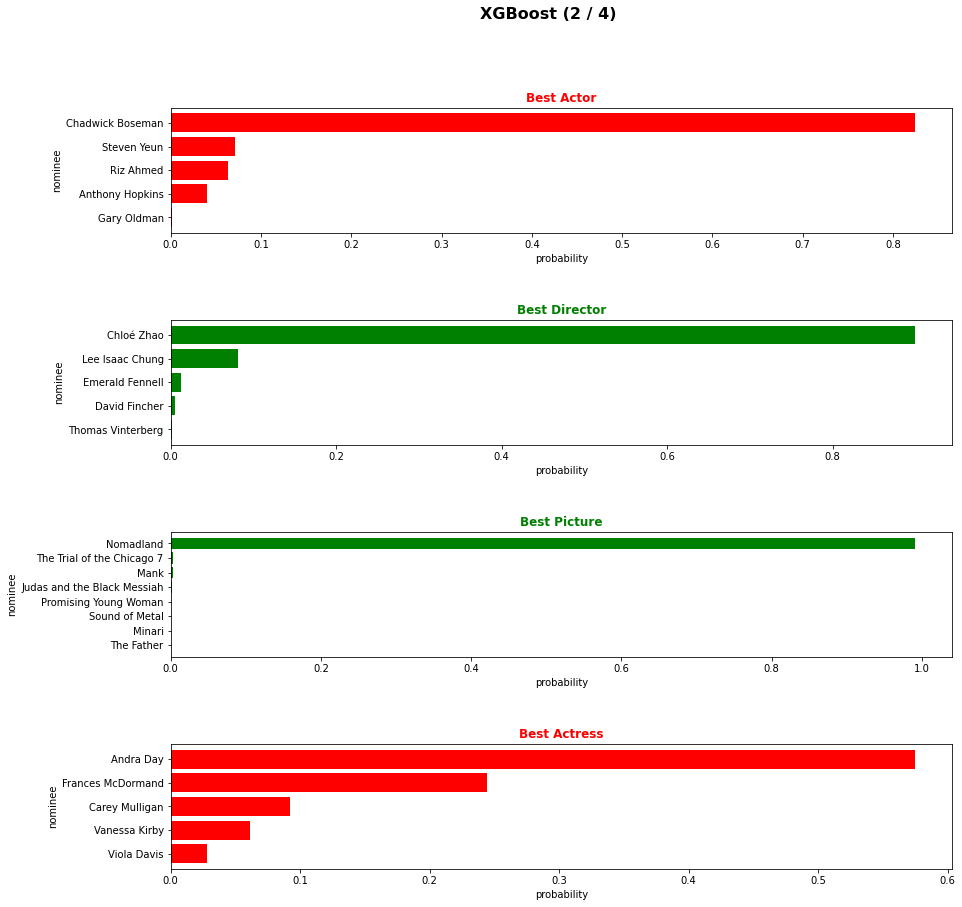

In [21]:
plot_predictions('XGBoost', predict_xgboost)

### XGBoost (Only major genres)

In [22]:
def predict_xgboost_major(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)
    movies, test_X = get_test(category)
    
    train_X = clear_non_major(train_X)
    test_X = clear_non_major(test_X)
        
    xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)
    xgbc.fit(train_X, train_Y)
    
    probs = xgbc.predict_proba(test_X)[:, 1]
    movies['prob'] = probs / np.sum(probs)
    return movies.sort_values(by='prob')

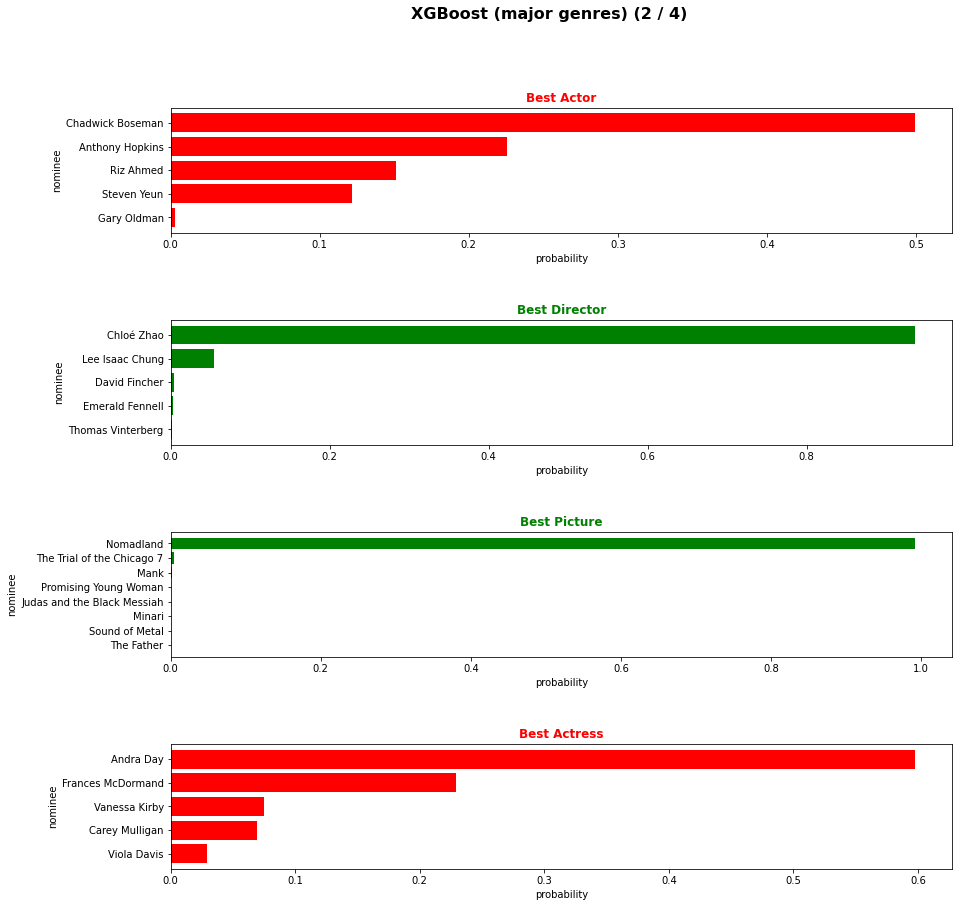

In [23]:
plot_predictions('XGBoost (major genres)', predict_xgboost_major)

### XGBoost (only important)

In [24]:
def predict_xgboost_important(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)
    movies, test_X = get_test(category)
    
    train_X = train_X[important]
    test_X = test_X[important]
    
    xgbc = XGBClassifier(use_label_encoder=False, verbosity=0)
    xgbc.fit(train_X, train_Y)
    
    probs = xgbc.predict_proba(test_X)[:, 1]
    movies['prob'] = probs / np.sum(probs)
    return movies.sort_values(by='prob')

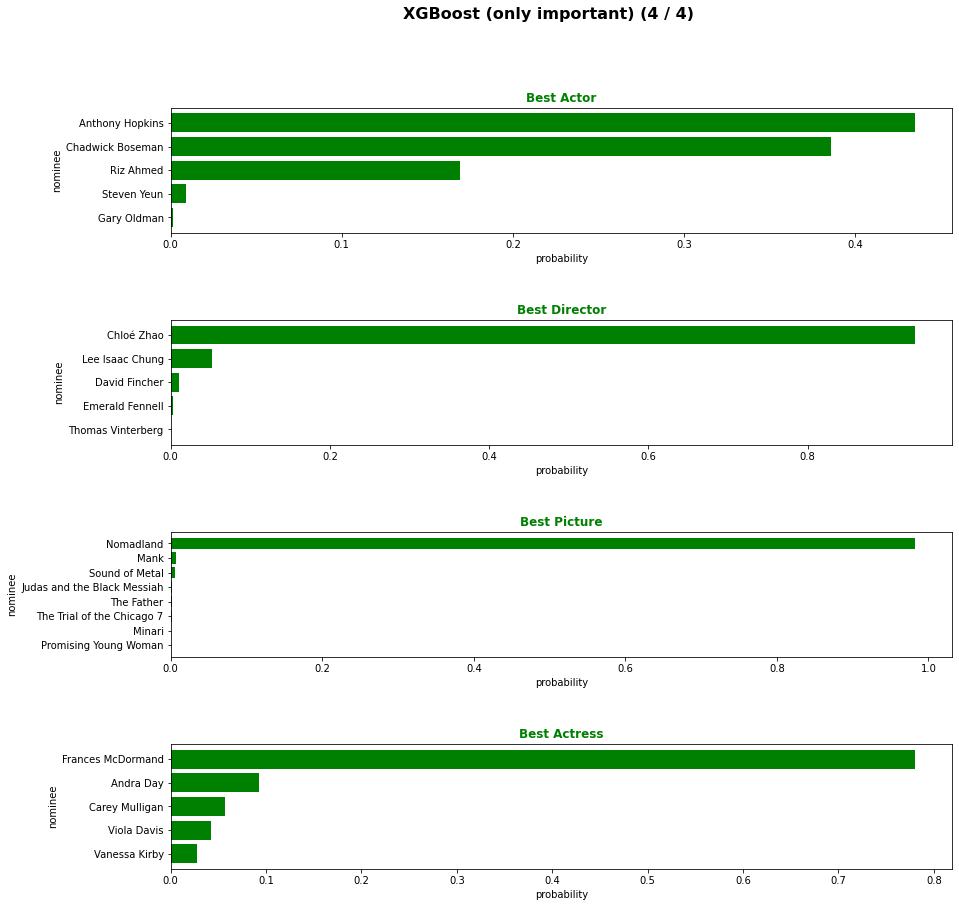

In [25]:
plot_predictions('XGBoost (only important)', predict_xgboost_important)

### Lightgbm

In [26]:
def predict_lightgbm(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category) 
    lgbmc = LGBMClassifier()
    lgbmc.fit(train_X, train_Y)
    return predict(lgbmc, category)

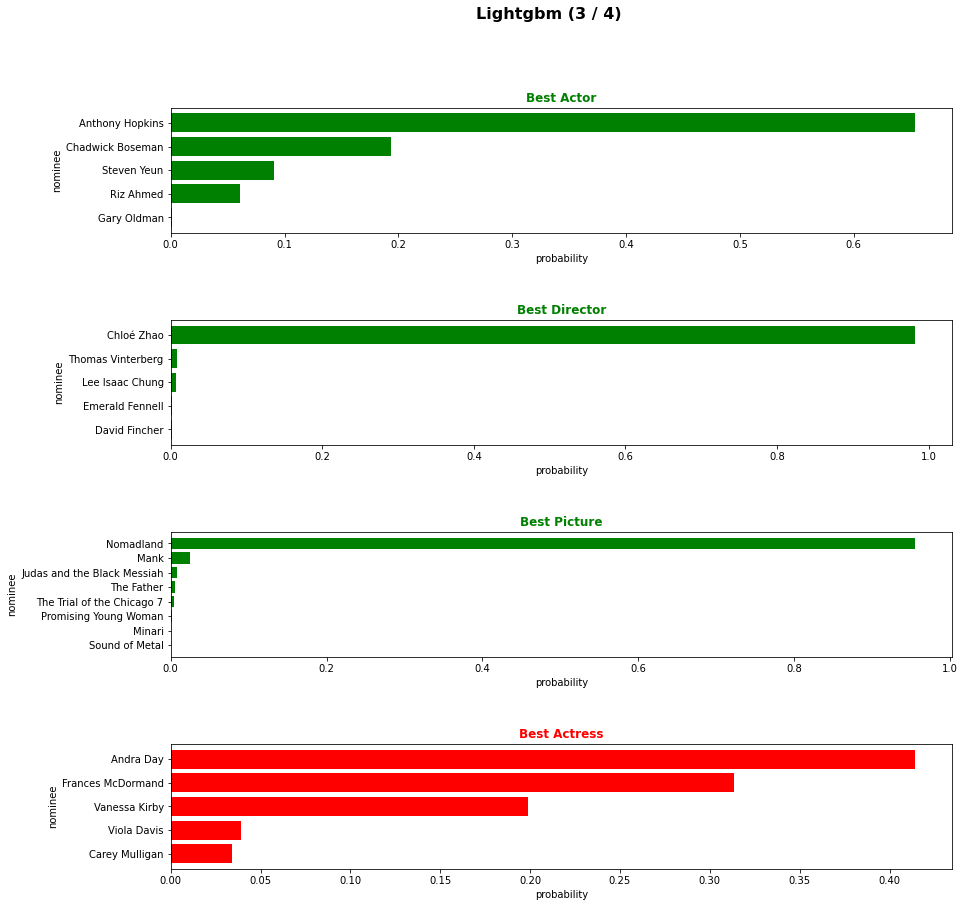

In [27]:
plot_predictions('Lightgbm', predict_lightgbm)

### Lightgbm (only important)

In [28]:
def predict_lightgbm_important(category: str) -> pd.DataFrame:
    train_X, train_Y = get_train(category)
    movies, test_X = get_test(category)
    
    train_X = train_X[important]
    test_X = test_X[important]
    
    lgbmc = LGBMClassifier()
    lgbmc.fit(train_X, train_Y)
    
    probs = lgbmc.predict_proba(test_X)[:, 1]
    movies['prob'] = probs / (np.sum(probs) + np.finfo(float).eps)
    return movies.sort_values(by='prob')

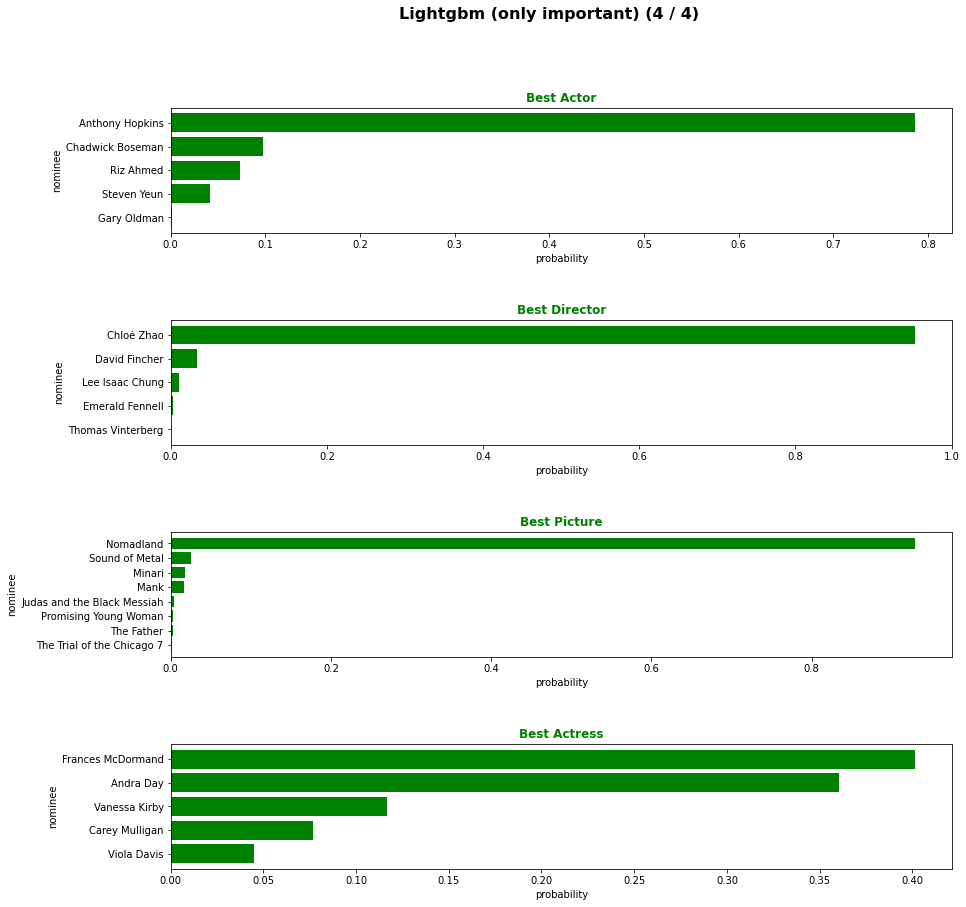

In [29]:
plot_predictions('Lightgbm (only important)', predict_lightgbm_important)